In [1]:
import torch
import datasets
from torch.utils.data import Dataset
# from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPProcessor, CLIPModel
from tqdm.auto import tqdm
# from PIL import Image
import numpy as np
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
import joblib
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define classes
classes = ["Asian", "Indian", "Black", "White", "Middle Eastern", "Latino Hispanic"]

In [4]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Load model and pre-processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [6]:
def get_embedding_and_zs(sample):
    # import pdb; pdb.set_trace()
    # Gender prediction
    inputs = processor(text=["the face of a man", "the face of a woman"], images=sample["image"], return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    gender_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    
    sample["zs_gender_clip"] = [int(gp) for gp in gender_pred]
    # Store embeddings
    sample["embeddings"] = outputs.image_embeds
    
    # Race prediction
    # # In the label, if the race is east or southeast asian, set 0 - merge the classes (for deepface to adapt)
    for idx, race in enumerate(sample["race"]):
        if race in {0,6}:
            sample["race"][idx] = 0
    inputs = processor(text=["Asian", "Indian", "Black", "White", "Middle Eastern", "Latino Hispanic"], images=sample["image"], return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    race_pred = logits_per_image.argmax(dim=1) # we can take the argmax
    
    sample["zs_race_clip"] = [int(rp) for rp in race_pred]
    return sample
    

In [7]:
# Load training data
train_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split='train', verification_mode="no_checks")
# train_ds = train_ds.shuffle(seed=42).select([i for i in range(1_000)]) # Take only first 20_000 images
train_ds = train_ds.shuffle(seed=42)
train_ds = train_ds.map(get_embedding_and_zs, batched = True, batch_size=16)

In [8]:
X_train_embeddings = train_ds["embeddings"]

In [9]:
X_train_labels = train_ds["race"]

In [10]:
X_train_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(np.array(X_train_embeddings))

C:\Users\Debadyuti\AppData\Roaming\Python\Python310\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [11]:
X_train_embedded.shape

(86744, 2)

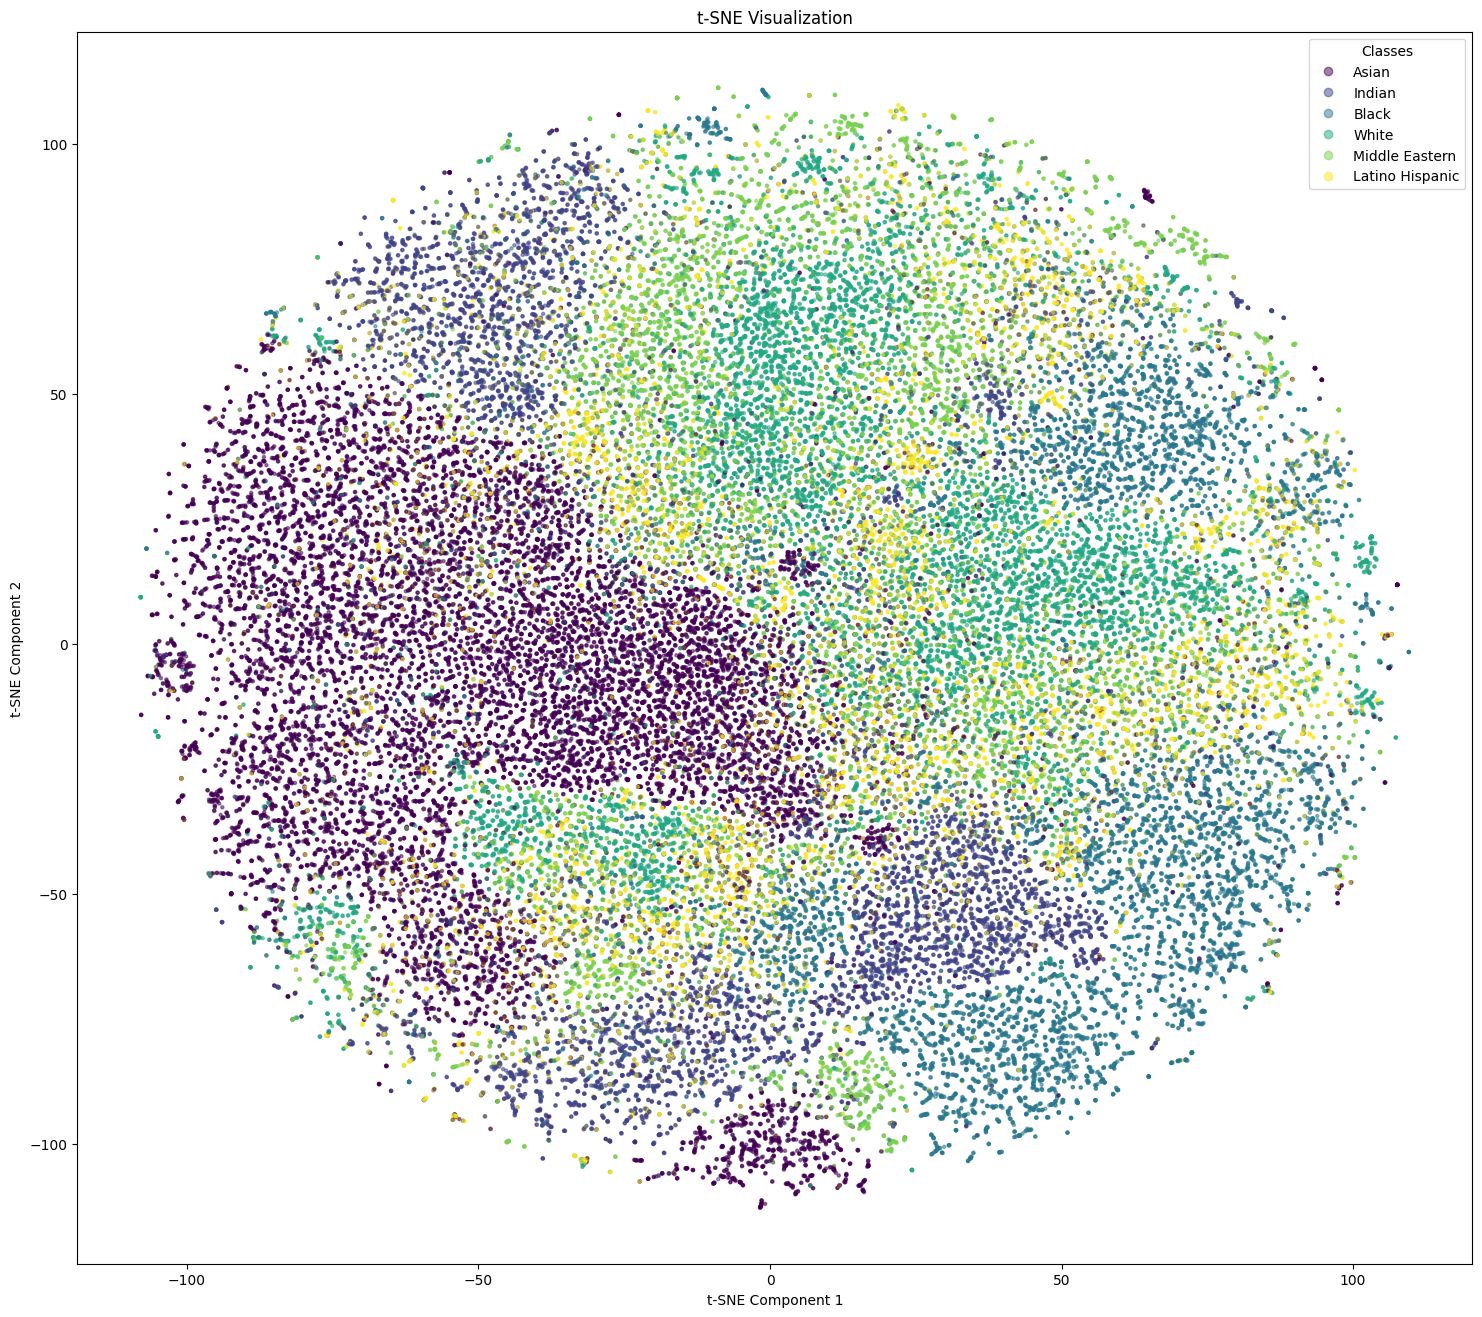

In [14]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_train_embedded[:, 0], X_train_embedded[:, 1], c=X_train_labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")

# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.show()

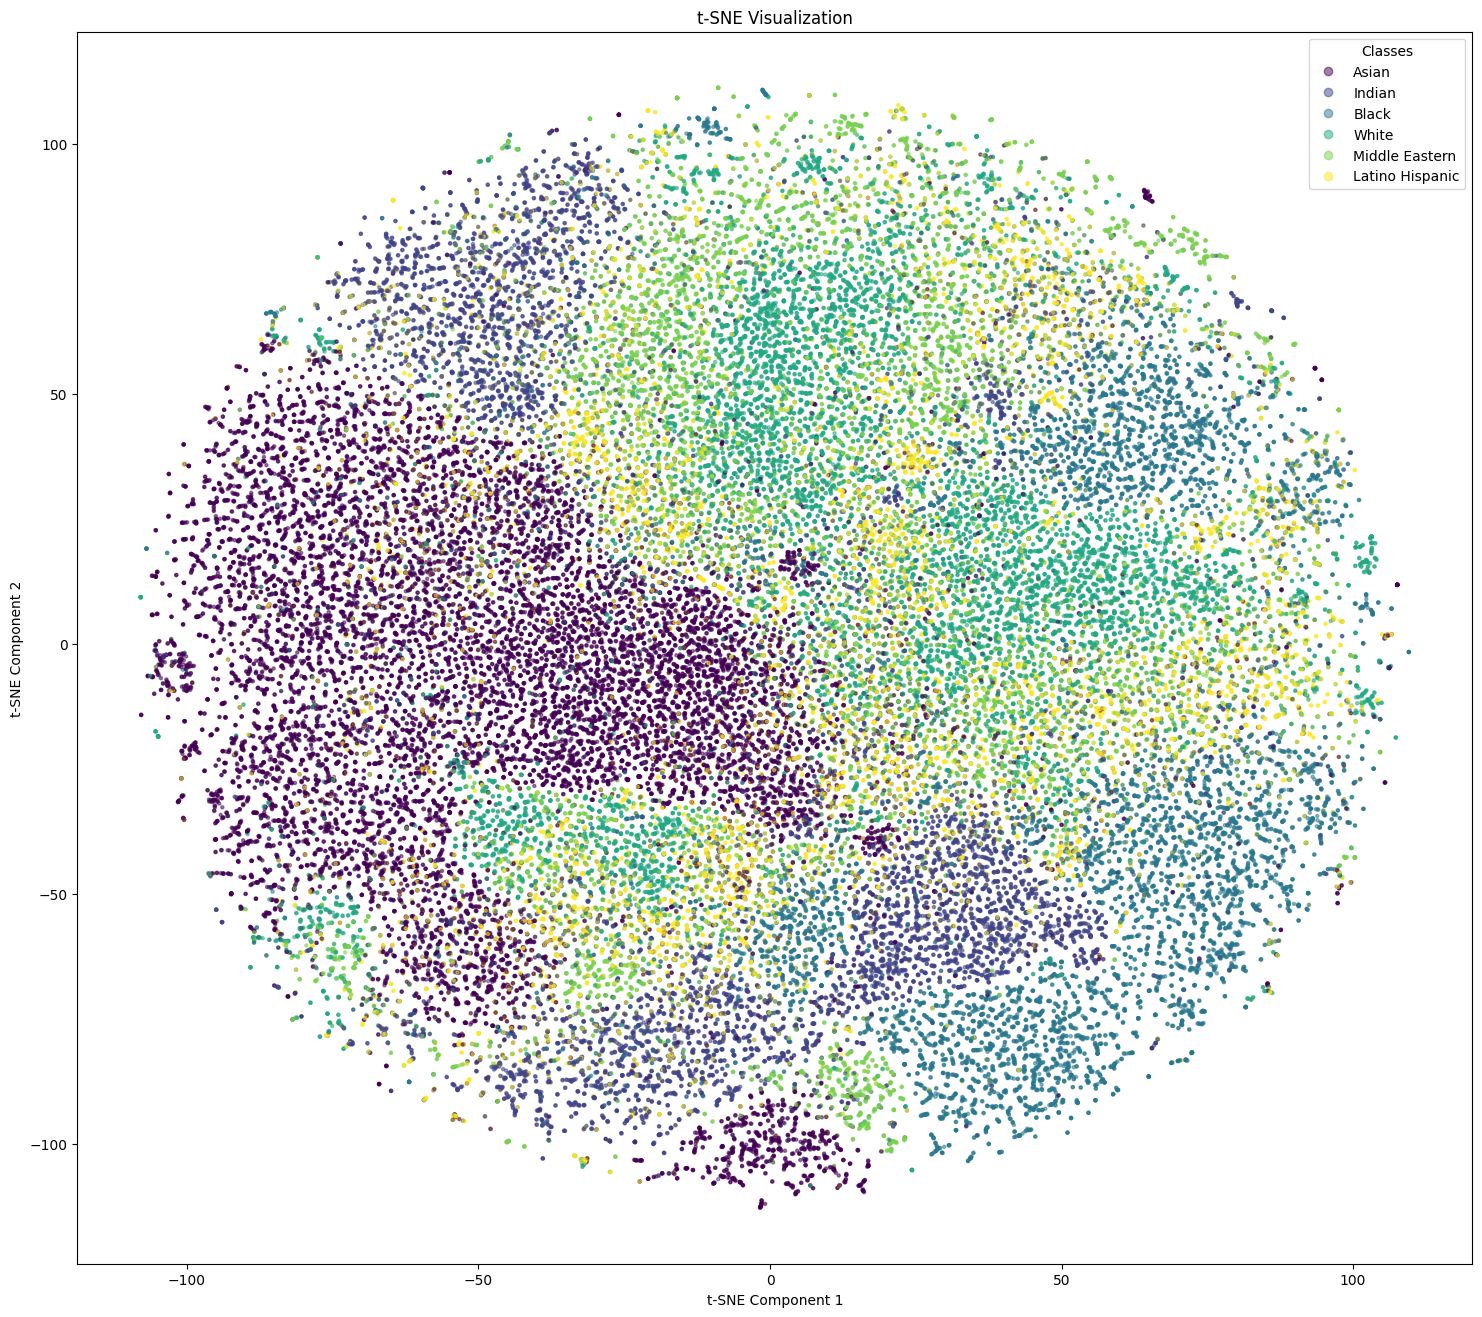

In [15]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_train_embedded[:, 0], X_train_embedded[:, 1], c=X_train_labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")


# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.savefig("training_fairface_tsne.png")

In [16]:
for idx, race in enumerate(["Asian", "Indian", "Black", "White", "Middle Eastern", "Latino Hispanic"]):
    race_mask = np.array(X_train_labels) == idx
    y_true = np.array(X_train_labels)[race_mask]
    y_preds = np.array(train_ds["zs_race_clip"])[race_mask]
    race_acc = np.sum(y_true == y_preds) / len(y_true) * 100
    print(f"Zero-shot accuracy for {race}(class-{idx}): {race_acc:.2f}%")

Zero-shot accuracy for Asian(class-0): 89.12%
Zero-shot accuracy for Indian(class-1): 80.64%
Zero-shot accuracy for Black(class-2): 5.57%
Zero-shot accuracy for White(class-3): 5.03%
Zero-shot accuracy for Middle Eastern(class-4): 29.25%
Zero-shot accuracy for Latino Hispanic(class-5): 65.93%


array([0.89117061, 0.80639662, 0.05566909, 0.05034186, 0.29253472,
       0.65931024])

In [22]:
np.array(X_train_labels) == idx

array([False,  True, False, ..., False, False,  True])

In [17]:
# Load validation data and test on this
valid_ds = datasets.load_dataset('HuggingFaceM4/FairFace', '1.25', split="validation", verification_mode="no_checks")
# valid_ds = valid_ds.shuffle(seed=42).select([i for i in range(6_000)]) # Take only first 6_000 images
valid_ds = valid_ds.shuffle(seed=42) 
valid_ds = valid_ds.map(get_embedding_and_zs, batched = True, batch_size=16)

In [18]:
X_val_embeddings = valid_ds["embeddings"]

In [19]:
X_val_labels = valid_ds["race"]

In [20]:
X_val_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(np.array(X_val_embeddings))

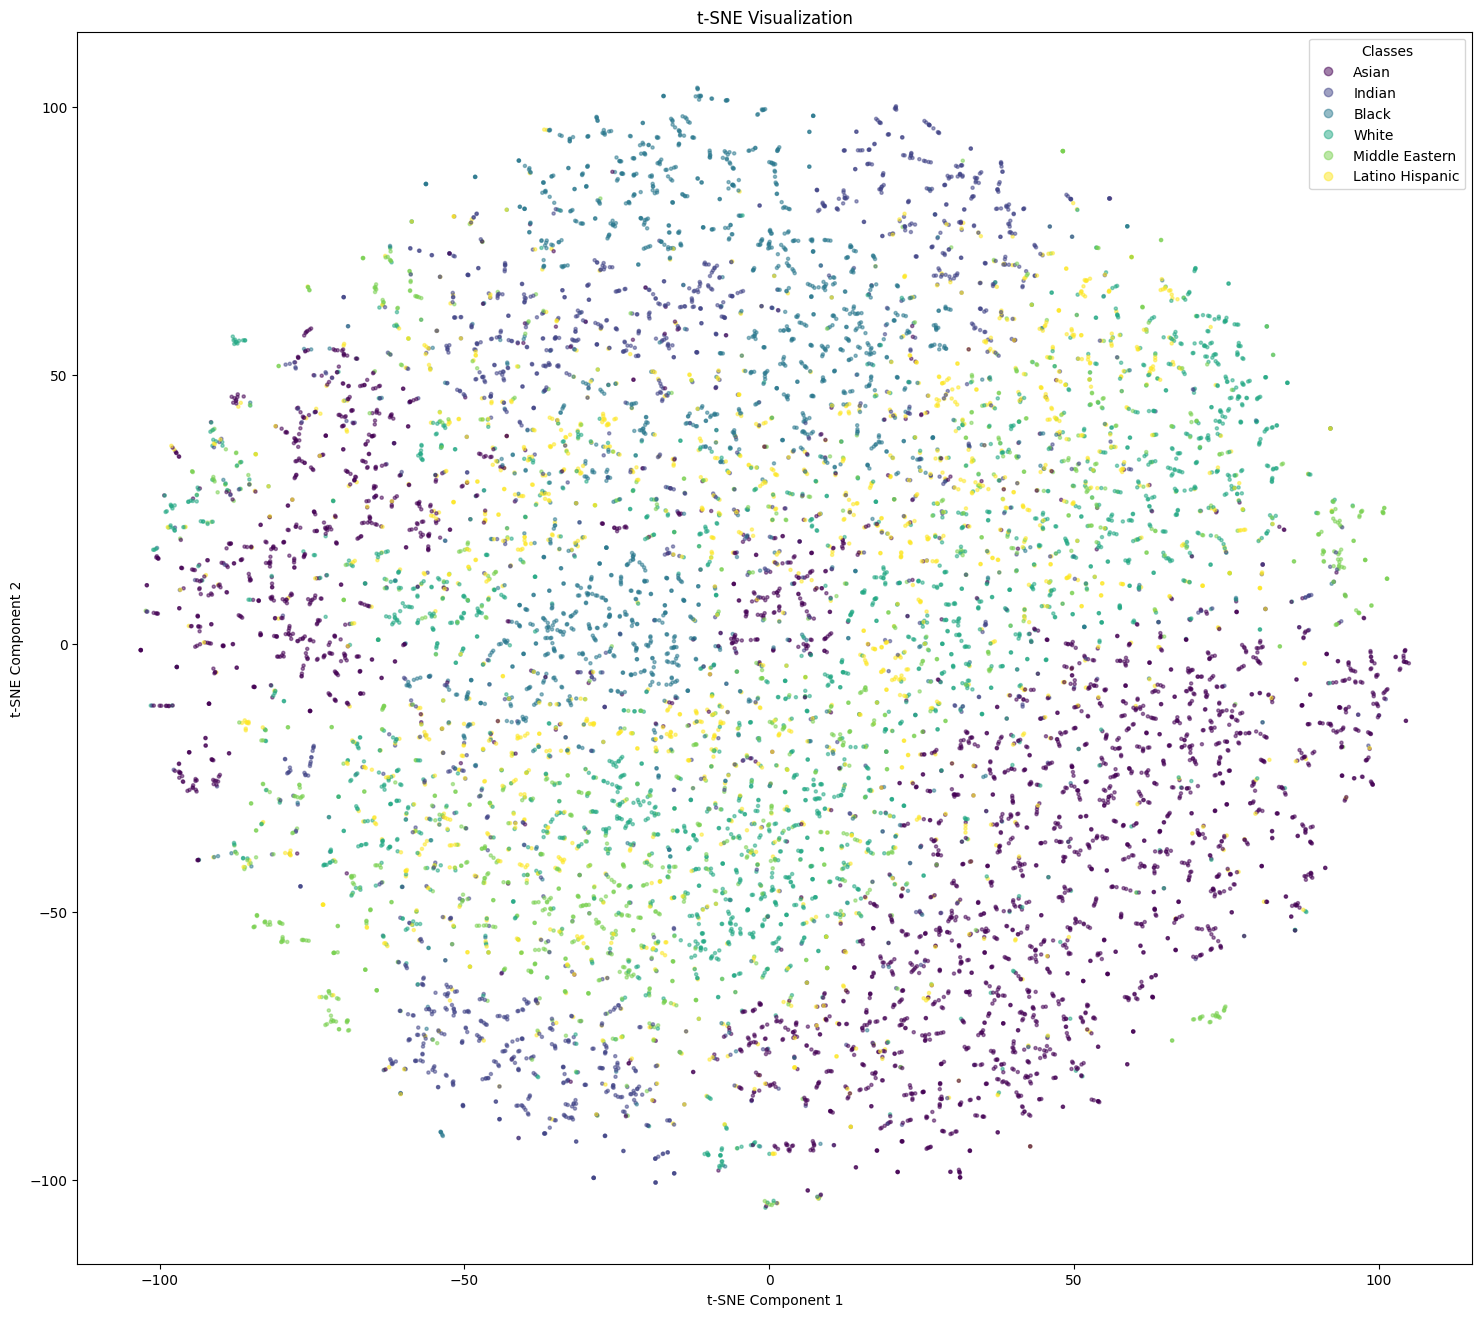

In [21]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_val_embedded[:, 0], X_val_embedded[:, 1], c=X_val_labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")


# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.show()

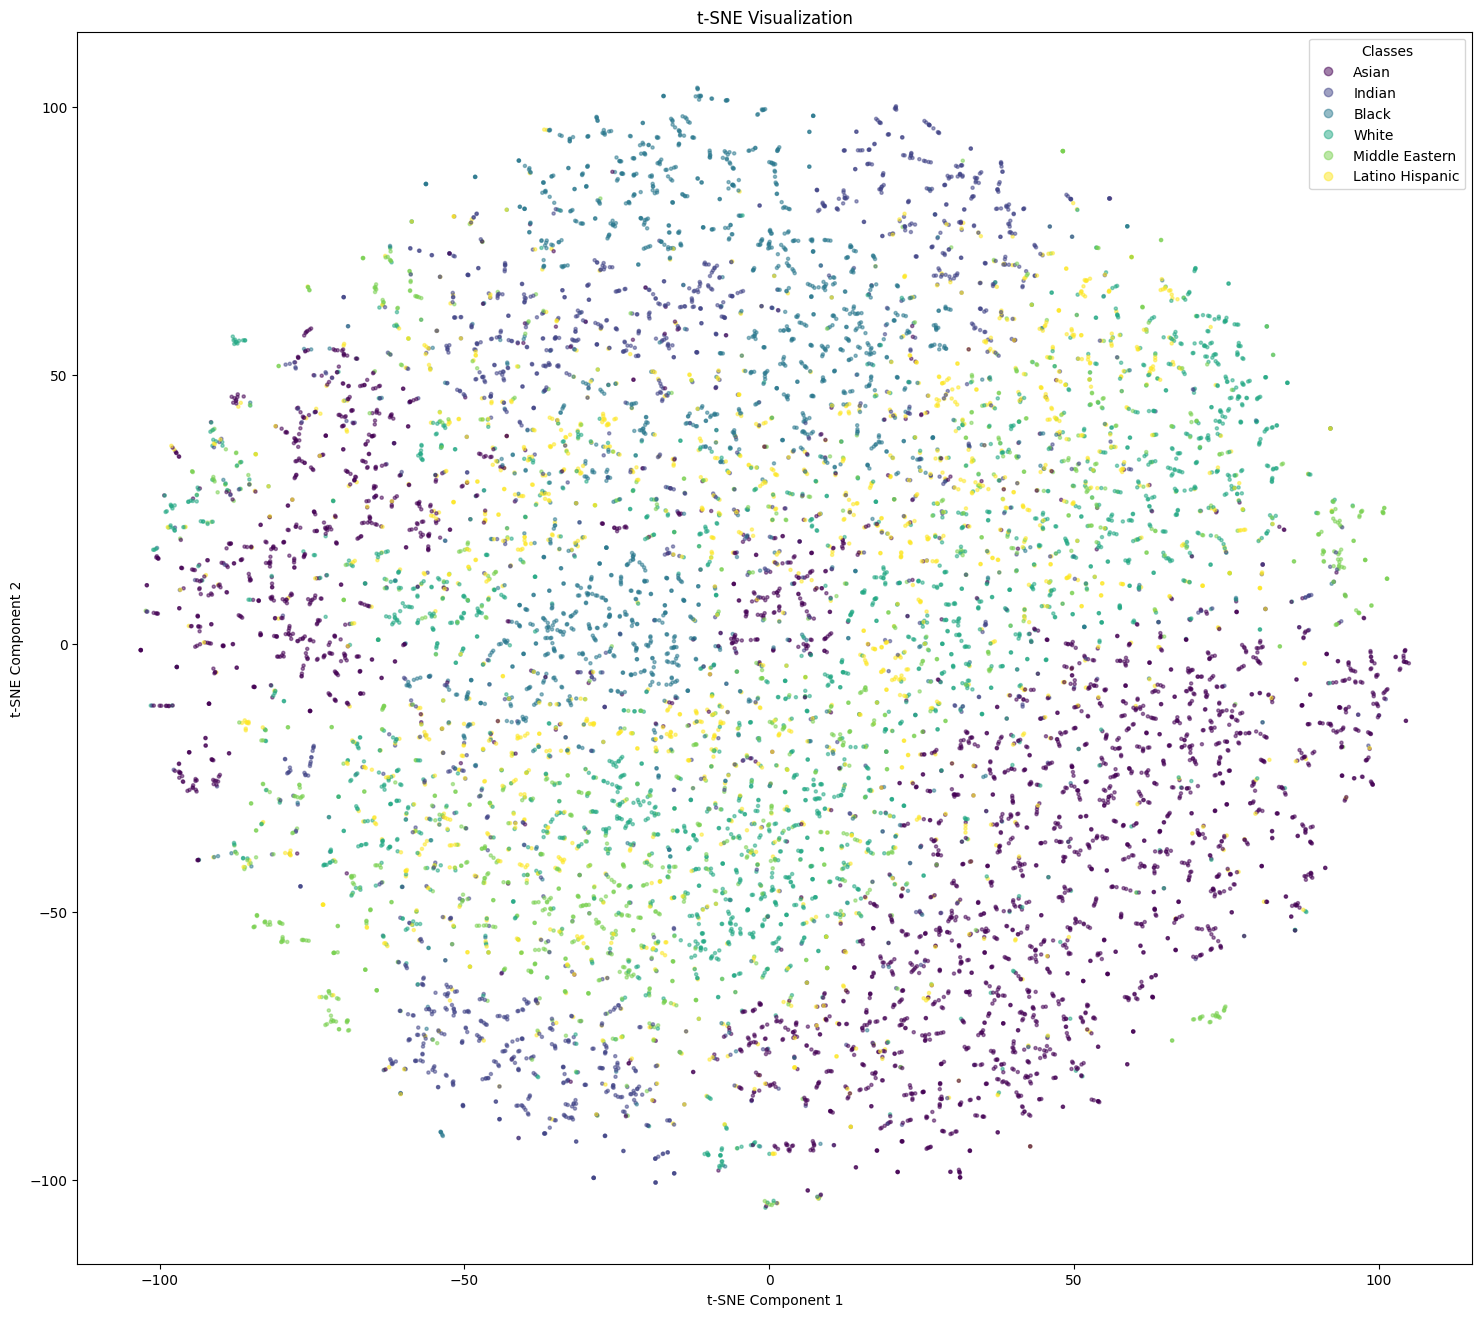

In [22]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_val_embedded[:, 0], X_val_embedded[:, 1], c=X_val_labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")


# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.savefig("validation_fairface_tsne.png")